In [1]:
import numpy as np
def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2024-09-23 03:20:02--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  3.49MB/s    in 23s     

2024-09-23 03:20:26 (3.52 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
import tensorflow as tf
from tensorflow import keras
dataset = keras.utils.text_dataset_from_directory(
    directory="aclImdb", label_mode=None, batch_size=256)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 100006 files belonging to 1 classes.


In [4]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 100
vocab_size = 15000
text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
text_vectorization.adapt(dataset)

In [5]:
def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)
    x = vectorized_sequences[:, :-1]
    y = vectorized_sequences[:, 1:]
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super(TransformerDecoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [7]:
from tensorflow.keras import layers
embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

In [8]:
import numpy as np

tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback):
    def __init__(self,
                 prompt,
                 generate_length,
                 model_input_length,
                 temperatures=(1.,),
                 print_freq=1):
        self.prompt = prompt
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        self.temperatures = temperatures
        self.print_freq = print_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_freq != 0:
            return
        for temperature in self.temperatures:
            print("== Generating with temperature", temperature)
            sentence = self.prompt
            for i in range(self.generate_length):
                tokenized_sentence = text_vectorization([sentence])
                predictions = self.model(tokenized_sentence)
                next_token = sample_next(predictions[0, i, :])
                sampled_token = tokens_index[next_token]
                sentence += " " + sampled_token
            print(sentence)

prompt = "This movie"
text_gen_callback = TextGenerator(
    prompt,
    generate_length=50,
    model_input_length=sequence_length,
    temperatures=(0.2, 0.5, 0.7, 1., 1.5))

In [9]:
model.fit(lm_dataset, epochs=200, callbacks=[text_gen_callback])

Epoch 1/200
391/391 [==============================] - 186s 395ms/step - loss: 5.3585
== Generating with temperature 0.2
This movie movie has had the a two lot different is shots [UNK] and just accompanied the with storytelling animated situations nice to cinematography the unreal sound the was need strong to and them that the was first muddled viewing [UNK] at often least some i kind think of too this much
== Generating with temperature 0.5
This movie was is a so boring bad the i cheap still written never given seen one it of a the cover best lets [UNK] see so it that makes omar you actually see more just english youre but looking this for a over joy it i will was give more it
== Generating with temperature 0.7
This movie film can wasnt stopped my hanged rarely her experience about with one the of films the the first first time fascination still with once was but in i look also in more this about version and of i the had directors the would people either get i [UNK] guess [UNK]
== Gen

391/391 [==============================] - 163s 417ms/step - loss: 4.3149
== Generating with temperature 0.2
This movie is is quite so a [UNK] complete while waste there [UNK] will from be this a film crazy that movie [UNK] is because about it a is bunch a of drag teenage on kids and in a their remote high country school thats actually it too good absurd for the
== Generating with temperature 0.5
This movie movie was is completely called specifically david [UNK] [UNK] [UNK] character me shoot from anyone the who limited knew speaking myself of that pretentious it movie reminded ever me of of my [UNK] [UNK] this [UNK] movie adventure was a explosive classic [UNK] i of was the irish disney [UNK]
== Generating with temperature 0.7
This movie movie came was in several in days this last so month when i i missed played the it [UNK] again movie tonight about and a loving great view cast of revealing the little community french battling music the with movie the producer [UNK] bill [UNK] [UNK] 

KeyboardInterrupt: 

# 딥드림

450560/440742 [==============================] - 0s 1us/step


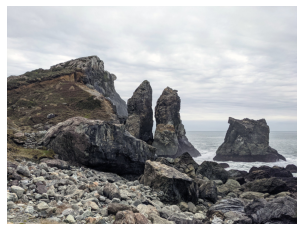

In [10]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

# 사전 훈련모델 inception_v3 사용

In [11]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


# 레이어 세팅
- 레이어가 겁나 많은데 mix 레이어를 선택한 이유는 뭘까?
    - 다른 레이어는 어떤 역할을 하지?
- 

In [21]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# 함수 API를 사용해서 feature_extractor 함수 설정 - output 위에서 세팅한 레이어의 output을 출력으로 받는다
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [23]:
outputs_dict.keys()

dict_keys(['mixed4', 'mixed5', 'mixed6', 'mixed7'])

# 손실계산
- 어떤 손실이 계산되는거지?

- 

In [13]:
def compute_loss(input_image):
    features = feature_extractor(input_image) # 활성화를 추출? -> concat layer의 아웃풋을 추출
    loss = tf.zeros(shape=())
    for name in features.keys():
        # 위에서 설정한 가중치
        coeff = layer_settings[name]
        # 실제 값
        activation = features[name]
        # reduce mean이 뭐지
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [14]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... 스텝 {i}에서 손실 값: {loss:.2f}")
    return image

In [15]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [16]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img += 1.0
    img *= 127.5
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [17]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"{shape} 크기의 {i}번째 옥타브 처리")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

(459, 612) 크기의 0번째 옥타브 처리
... 스텝 0에서 손실 값: 0.80
... 스텝 1에서 손실 값: 1.07
... 스텝 2에서 손실 값: 1.44
... 스텝 3에서 손실 값: 1.82
... 스텝 4에서 손실 값: 2.16
... 스텝 5에서 손실 값: 2.50
... 스텝 6에서 손실 값: 2.85
... 스텝 7에서 손실 값: 3.20
... 스텝 8에서 손실 값: 3.54
... 스텝 9에서 손실 값: 3.88
... 스텝 10에서 손실 값: 4.21
... 스텝 11에서 손실 값: 4.55
... 스텝 12에서 손실 값: 4.91
... 스텝 13에서 손실 값: 5.26
... 스텝 14에서 손실 값: 5.59
... 스텝 15에서 손실 값: 5.94
... 스텝 16에서 손실 값: 6.31
... 스텝 17에서 손실 값: 6.63
... 스텝 18에서 손실 값: 6.95
... 스텝 19에서 손실 값: 7.27
... 스텝 20에서 손실 값: 7.64
... 스텝 21에서 손실 값: 7.93
... 스텝 22에서 손실 값: 8.26
... 스텝 23에서 손실 값: 8.57
... 스텝 24에서 손실 값: 8.85
... 스텝 25에서 손실 값: 9.19
... 스텝 26에서 손실 값: 9.47
... 스텝 27에서 손실 값: 9.78
... 스텝 28에서 손실 값: 10.02
... 스텝 29에서 손실 값: 10.31
(642, 857) 크기의 1번째 옥타브 처리
... 스텝 0에서 손실 값: 1.60
... 스텝 1에서 손실 값: 2.62
... 스텝 2에서 손실 값: 3.41
... 스텝 3에서 손실 값: 4.01
... 스텝 4에서 손실 값: 4.56
... 스텝 5에서 손실 값: 5.06
... 스텝 6에서 손실 값: 5.56
... 스텝 7에서 손실 값: 5.99
... 스텝 8에서 손실 값: 6.43
... 스텝 9에서 손실 값: 6.83
... 스텝 10에서 손실 값: 7.18
... 스텝 11에서 손실 값: 7.56


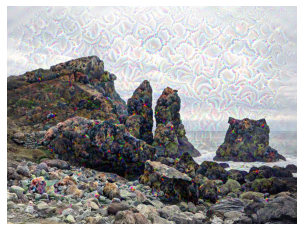

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 파일 불러오기
img = Image.open("dream.png")

# 이미지 출력
plt.imshow(img)
plt.axis('off')  # 축을 숨깁니다.
plt.show()

In [40]:
img_tensor = tf.random.uniform(shape=(4, 4, 3), minval=0, maxval=1)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    print(x.shape)
    features = tf.reshape(x, (tf.shape(x)[0], -1)) 
    print(features.shape)
    gram = tf.matmul(features, tf.transpose(features))
    print(gram.shape)
    return gram 

In [41]:
img_tensor.shape

TensorShape([4, 4, 3])

In [42]:
result = gram_matrix(img_tensor)

(3, 4, 4)
(3, 16)
(3, 3)
